# Library imports

In [61]:
# 📦 Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 📂 Préparation des données

In [62]:
# 📂 Préparation des données
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [63]:
train_data = datagen.flow_from_directory(
    '../dataset_corrige_animals/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 435 images belonging to 2 classes.


In [64]:
val_data = datagen.flow_from_directory(
    '../dataset_corrige_animals/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 108 images belonging to 2 classes.


In [65]:
# 📝 Vérification des classes
print(train_data.class_indices)

{'injured_animals': 0, 'not_injured_animals': 1}


In [66]:
# 2. Chargement du modèle MobileNetV2 pré-entraîné
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze MobileNetV2

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Défiger à partir de la couche 100
for layer in base_model.layers[100:]:
    layer.trainable = True

# Recompiler avant de continuer l'entraînement
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
# 🛑 Callback pour éviter l'overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [68]:
# 🚀 Entraînement
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15
14/14 [==============================] - 29s 2s/step - loss: 0.8848 - accuracy: 0.4943 - val_loss: 0.9906 - val_accuracy: 0.5000
Epoch 2/15
14/14 [==============================] - 18s 1s/step - loss: 0.9591 - accuracy: 0.4598 - val_loss: 1.0153 - val_accuracy: 0.4630
Epoch 3/15
14/14 [==============================] - 32s 2s/step - loss: 0.8381 - accuracy: 0.5011 - val_loss: 0.9308 - val_accuracy: 0.4815
Epoch 4/15
14/14 [==============================] - 35s 2s/step - loss: 0.8640 - accuracy: 0.4851 - val_loss: 1.0017 - val_accuracy: 0.4630
Epoch 5/15
14/14 [==============================] - 38s 3s/step - loss: 0.8411 - accuracy: 0.5241 - val_loss: 0.9414 - val_accuracy: 0.4722
Epoch 6/15
14/14 [==============================] - 41s 3s/step - loss: 0.8777 - accuracy: 0.4759 - val_loss: 0.9653 - val_accuracy: 0.4537
Epoch 7/15
14/14 [==============================] - 37s 3s/step - loss: 0.8302 - accuracy: 0.5057 - val_loss: 0.9331 - val_accuracy: 0.4444
Epoch 8/15
14/14 [==

In [69]:
# 📈 Courbes de précision et de perte
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [70]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


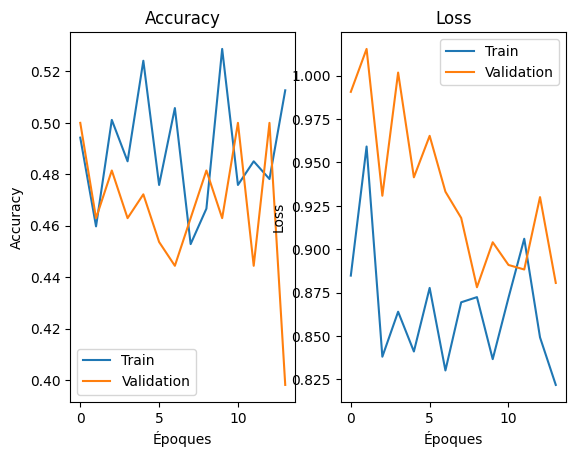

In [71]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()

plt.show()


# 📊 Évaluation finale

In [72]:
# 📊 Évaluation finale
val_loss, val_acc = model.evaluate(val_data)
print(f"\n✅ Validation Accuracy : {val_acc:.2f}")

4/4 [==============================] - 7s 1s/step - loss: 0.8850 - accuracy: 0.4722

✅ Validation Accuracy : 0.47


# 📏 Matrice de confusion

4/4 [==============================] - 11s 1s/step


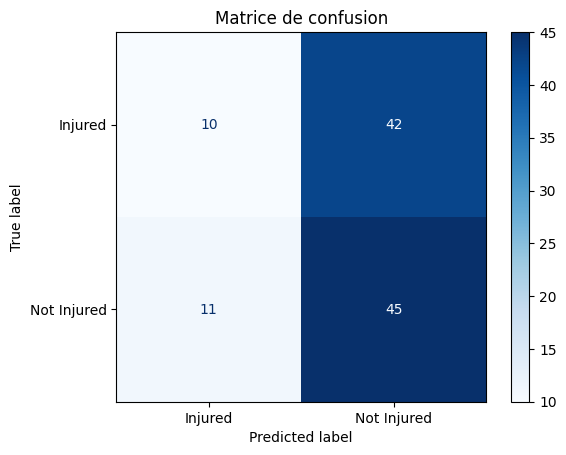

In [73]:
# 📏 Matrice de confusion
val_data.reset()
predictions = model.predict(val_data)
y_pred = (predictions > 0.5).astype(int).ravel()
y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Injured', 'Not Injured'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

In [74]:
# Rapport classification
print(classification_report(y_true, y_pred, target_names=['Injured', 'Not Injured']))

              precision    recall  f1-score   support

     Injured       0.48      0.19      0.27        52
 Not Injured       0.52      0.80      0.63        56

    accuracy                           0.51       108
   macro avg       0.50      0.50      0.45       108
weighted avg       0.50      0.51      0.46       108



# 💾 Sauvegarde du modèle

In [75]:
# 💾 Sauvegarde du modèle
model.save('injury_detector_model.h5')
print("✅ Modèle sauvegardé sous 'injury_detector_model.h5'")

✅ Modèle sauvegardé sous 'injury_detector_model.h5'
